<a href="https://colab.research.google.com/github/MaEvGoR/CT_notebooks/blob/master/EvgrafovMA_BS18_01_2nd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Input
**Consider spring-mass-damper system**


---



$mx'' + bx' + kx = F$

$\begin{bmatrix}x'\\x''\end{bmatrix}$
$=$
$\begin{bmatrix}0. & 1.\\-\frac{k}{m} & -\frac{b}{m}\end{bmatrix}$
$\begin{bmatrix}x\\x'\end{bmatrix}$
$+$
$\begin{bmatrix}0\\\frac{1}{m}\end{bmatrix}$
$F$


---


**and complete the following tasks**

###Task1
  Design PD-controller that tracks time varying reference states i.e.
 $\begin{bmatrix} 
 x^{*}(t) & \dot{x^{*}}(t) \\
 \end{bmatrix}^{T}$
as closely as possible. Test your controller on different trajectories.



---


$F = -ke = -$
$\begin{bmatrix}
k_p & k_d\\
\end{bmatrix}e = -$
$\begin{bmatrix}
k_p & k_d\\
\end{bmatrix}(x^{*} - x) = -$
$\begin{bmatrix}
k_p & k_d\\
\end{bmatrix}$
$\begin{bmatrix}
x^{*} - x\\
\dot{x^{*}} - \dot{x}\\
\end{bmatrix}$

---

###Task2
Find $k_p$ and $k_d$ such that there are no oscillations and no overshoot in the system. Prove it on step input signal;


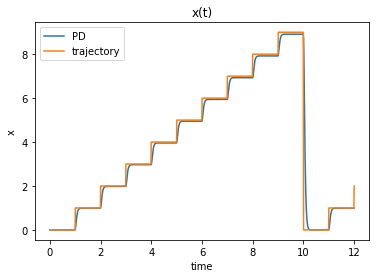

In [0]:
import numpy as np
import scipy.integrate as integrate
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
import random

k = 10
m = 1
b = 1



A = np.array([[  0,    1  ],
              [-k/m, -b/m]])

B = np.array([[ 0 ],
              [1/m]])

kp = 1000
kd = 60

kpd = np.array([[kp, kd]])

def x_star(t):
  # Because we are create x_star by hand
  # we should also input derivative by ourself

  # Possible trajectory
  
  # x_star = math.sin(t)
  # x_star_diff = math.cos(t)


  # Constant trajectory

  # x_star = 2       # here we input actual trajectory
  # x_star_diff = 0  # here we input derivative of this trajectory


  # Step input signal trajectory
  
  x_star = math.floor(t)%10
  x_star_diff = 0

  return np.array([[x_star],     
                   [x_star_diff]])    

def normalize_x(x):
  return x.reshape((2,1))

def calculate(x, t):
  normal_x = normalize_x(x)

  a_dot_x = A.dot(normal_x)

  e = x_star(t) - normal_x

  F = -kpd.dot(e)
  b_dot_F = B*F
  
  result = a_dot_x - b_dot_F
  return result.transpose().flatten()

x_0 = [0, 0]

time = np.linspace(0, 12, 1000)
solution = odeint(calculate, x_0, time)

trajectory = [x_star(t)[0] for t in time]

control, = plt.plot(time, solution[:, [0]], label='PD')
needed, = plt.plot(time, trajectory, label='trajectory')

plt.legend(handles=[control, needed], loc='best')
plt.title('x(t)')

plt.xlabel('time')
plt.ylabel('x')

plt.show()

###Task3
Prove that spring-mass-damper system is stable with PD-controller for kp and kd of your choice.


---
$A-BK \prec 0 \Longrightarrow$ system is stable

---
PS. plot is just for fun 



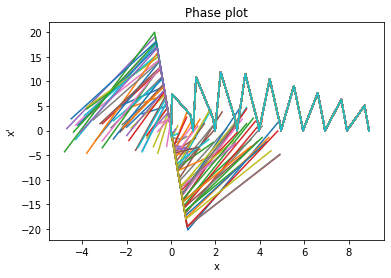

[-30.5+8.93028555j -30.5-8.93028555j]


In [0]:
for i in range(100):
  x_0_phase = [random.randint(-50,50)/10, random.randint(-50,50)/10]
  time_phase = np.linspace(0, 10, 100)
  solution_phase = odeint(calculate, x_0_phase, time_phase)

  plt.plot(solution_phase[:, [0]], solution_phase[:, [1]])

plt.xlabel('x')
plt.ylabel("x'")
plt.title("Phase plot")
plt.show()

print(np.linalg.eig(A-B.dot(kpd))[0])

###Task4
Implement PI/PID controller and compare it to PD controller.


---

The problem is that in system with $K_i$

$u = -K_p*e - K_d*\dot{e}-K_i*I_e, where... I_e = \int_{}edt = \sum_{t=t_0}^{T}e(t)$

So, I write additional thing inside the calculate function. Because of the fact that odeint calculate ODE in strange order, I explicitly added some values inside the dict in case to sum all previous errors. You can see plot of PID control before the code block. 

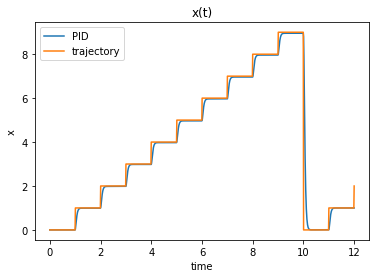

In [0]:
ki = 2.7

errors = {}
for t in time:
  errors[t] = []

def calculate_with_k_i(x, t):
  normal_x = normalize_x(x)

  a_dot_x = A.dot(normal_x)

  e = x_star(t) - normal_x

  if t in errors.keys():
    errors[t].append(e.flatten()[0])
  else:
    for k in errors.keys():
      if k > t and abs(t-k) < 0.0008:
        errors[k].append(e.flatten()[0])
        errors[k] = [sum(errors[k])/len(errors[k])]
        break
  
  error_sums = 0
  for k in errors.keys():
    error_sums += errors[k][0] if len(errors[k]) > 0 and k<t else 0

  F = -kpd.dot(e) - ki*error_sums
  b_dot_F = B*F
  
  result = a_dot_x - b_dot_F
  return result.transpose().flatten()


solution = odeint(calculate_with_k_i, x_0, time)

trajectory = [x_star(t)[0] for t in time]

control, = plt.plot(time, solution[:, [0]], label='PID')
needed, = plt.plot(time, trajectory, label='trajectory')

plt.legend(handles=[control, needed], loc='best')
plt.title('x(t)')

plt.xlabel('time')
plt.ylabel('x')

plt.show()

##Results
So, as expected, our system become better, because now we can handle small error, which are not handled by PD control. But calculations become harder. (Because of the odeint implementation inside the $scipy$ library). 